Опрос - https://goo.gl/forms/F9repCtzeP8av1uv1

## Синтаксические и семантические парсеры
* Парсер составляющих: http://tomato.banatao.berkeley.edu:8080/parser/parser.html
* Парсеры зависимостей: http://nlp.stanford.edu:8080/corenlp/process и http://demo.ark.cs.cmu.edu/parse
* Универсальные зависимости: http://universaldependencies.org/u/overview/syntax.html

## Векторная модель документа

In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
from gensim import corpora
documents = ["Human machine interface for lab abc computer applications",
             "A survey of user opinion of computer system response time",
             "The EPS user interface management system",
             "System and human system engineering testing of EPS",              
             "Relation of user perceived response time to error measurement",
             "The generation of random binary unordered trees",
             "The intersection graph of paths in trees",
             "Graph minors IV Widths of trees and well quasi ordering",
             "Graph minors A survey"]

C:\Users\sanek\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
2017-02-02 06:48:33,658 : INFO : 'pattern' package not found; tag filters are not available for English


Проведем токенизацию, удалим одиночные и общеупотребительные слова

In [3]:
# remove common words and tokenize
stoplist = set('for a of the and to in'.split())
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in documents]

# remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]

from pprint import pprint  # pretty-printer
pprint(texts)

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]


Теперь конвертируем документ в вектор, используя технику "мешко слов" (bow): (word_id, word_freq)

In [5]:
dictionary = corpora.Dictionary(texts)
dictionary.save('deerwester.dict')  # store the dictionary, for future reference
print(dictionary)

2017-02-02 06:52:40,473 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-02-02 06:52:40,476 : INFO : built Dictionary(12 unique tokens: ['minors', 'system', 'eps', 'interface', 'trees']...) from 9 documents (total 29 corpus positions)
2017-02-02 06:52:40,478 : INFO : saving Dictionary object under deerwester.dict, separately None
2017-02-02 06:52:40,522 : INFO : saved deerwester.dict


Dictionary(12 unique tokens: ['minors', 'system', 'eps', 'interface', 'trees']...)


In [6]:
print(dictionary.token2id)

{'minors': 11, 'system': 5, 'eps': 8, 'interface': 2, 'trees': 9, 'time': 3, 'user': 4, 'computer': 1, 'response': 7, 'survey': 6, 'graph': 10, 'human': 0}


Посмотрим векторное представление предлдожения по нашему словарю

In [7]:
new_doc = "Human computer interaction"
new_vec = dictionary.doc2bow(new_doc.lower().split())
print(new_vec)  # the word "interaction" does not appear in the dictionary and is ignored

[(0, 1), (1, 1)]


In [8]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('deerwester.mm', corpus)  # store to disk, for later use
for c in corpus:
    print(c)

2017-02-02 06:57:55,767 : INFO : storing corpus in Matrix Market format to deerwester.mm
2017-02-02 06:57:55,770 : INFO : saving sparse matrix to deerwester.mm
2017-02-02 06:57:55,772 : INFO : PROGRESS: saving document #0
2017-02-02 06:57:55,774 : INFO : saved 9x12 matrix, density=25.926% (28/108)
2017-02-02 06:57:55,780 : INFO : saving MmCorpus index to deerwester.mm.index


[(0, 1), (1, 1), (2, 1)]
[(1, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]
[(2, 1), (4, 1), (5, 1), (8, 1)]
[(0, 1), (5, 2), (8, 1)]
[(3, 1), (4, 1), (7, 1)]
[(9, 1)]
[(9, 1), (10, 1)]
[(9, 1), (10, 1), (11, 1)]
[(6, 1), (10, 1), (11, 1)]


## Поиск ключевых слов и похожих документов

In [10]:
dictionary = corpora.Dictionary.load('deerwester.dict')
corpus = corpora.MmCorpus('deerwester.mm') # comes from the first tutorial, "From strings to vectors"
print(corpus)

2017-02-02 07:04:50,532 : INFO : loading Dictionary object from deerwester.dict
2017-02-02 07:04:50,535 : INFO : loaded deerwester.dict
2017-02-02 07:04:50,538 : INFO : loaded corpus index from deerwester.mm.index
2017-02-02 07:04:50,539 : INFO : initializing corpus reader from deerwester.mm
2017-02-02 07:04:50,541 : INFO : accepted corpus with 9 documents, 12 features, 28 non-zero entries


MmCorpus(9 documents, 12 features, 28 non-zero entries)


Инициализирум нашу модель перехода от одного векторного представления в другое

In [13]:
from gensim import corpora, models, similarities
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model

2017-02-02 07:08:33,929 : INFO : collecting document frequencies
2017-02-02 07:08:33,932 : INFO : PROGRESS: processing document #0
2017-02-02 07:08:33,934 : INFO : calculating IDF weights for 9 documents and 11 features (28 matrix non-zeros)


Проверим, как она работает для одного документа

In [14]:
doc_bow = [(0, 1), (1, 1)]
print(tfidf[doc_bow]) # step 2 -- use the model to transform vectors

[(0, 0.7071067811865476), (1, 0.7071067811865476)]


и для всего корпуса

In [15]:
corpus_tfidf = tfidf[corpus]
for doc in corpus_tfidf:
    print(doc)

[(0, 0.5773502691896257), (1, 0.5773502691896257), (2, 0.5773502691896257)]
[(1, 0.44424552527467476), (3, 0.44424552527467476), (4, 0.3244870206138555), (5, 0.3244870206138555), (6, 0.44424552527467476), (7, 0.44424552527467476)]
[(2, 0.5710059809418182), (4, 0.4170757362022777), (5, 0.4170757362022777), (8, 0.5710059809418182)]
[(0, 0.49182558987264147), (5, 0.7184811607083769), (8, 0.49182558987264147)]
[(3, 0.6282580468670046), (4, 0.45889394536615247), (7, 0.6282580468670046)]
[(9, 1.0)]
[(9, 0.7071067811865475), (10, 0.7071067811865475)]
[(9, 0.5080429008916749), (10, 0.5080429008916749), (11, 0.695546419520037)]
[(6, 0.6282580468670046), (10, 0.45889394536615247), (11, 0.6282580468670046)]


Мы можем составлять цепочки моделей. Например, добавим латетную семантическую модель, переводящую tf-idf в 2-мерное пространство

In [16]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2) # initialize an LSI transformation
corpus_lsi = lsi[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

2017-02-02 07:12:21,301 : INFO : using serial LSI version on this node
2017-02-02 07:12:21,304 : INFO : updating model with new documents
2017-02-02 07:12:21,307 : INFO : preparing a new chunk of documents
2017-02-02 07:12:21,310 : INFO : using 100 extra samples and 2 power iterations
2017-02-02 07:12:21,313 : INFO : 1st phase: constructing (12, 102) action matrix
2017-02-02 07:12:21,315 : INFO : orthonormalizing (12, 102) action matrix
2017-02-02 07:12:21,332 : INFO : 2nd phase: running dense svd on (12, 9) matrix
2017-02-02 07:12:21,335 : INFO : computing the final decomposition
2017-02-02 07:12:21,337 : INFO : keeping 2 factors (discarding 47.565% of energy spectrum)
2017-02-02 07:12:21,340 : INFO : processed documents up to #9
2017-02-02 07:12:21,344 : INFO : topic #0(1.594): 0.703*"trees" + 0.538*"graph" + 0.402*"minors" + 0.187*"survey" + 0.061*"system" + 0.060*"response" + 0.060*"time" + 0.058*"user" + 0.049*"computer" + 0.035*"interface"
2017-02-02 07:12:21,346 : INFO : topic #

In [17]:
lsi.print_topics(2)

2017-02-02 07:14:43,876 : INFO : topic #0(1.594): 0.703*"trees" + 0.538*"graph" + 0.402*"minors" + 0.187*"survey" + 0.061*"system" + 0.060*"response" + 0.060*"time" + 0.058*"user" + 0.049*"computer" + 0.035*"interface"
2017-02-02 07:14:43,879 : INFO : topic #1(1.476): -0.460*"system" + -0.373*"user" + -0.332*"eps" + -0.328*"interface" + -0.320*"response" + -0.320*"time" + -0.293*"computer" + -0.280*"human" + -0.171*"survey" + 0.161*"trees"


[(0,
  '0.703*"trees" + 0.538*"graph" + 0.402*"minors" + 0.187*"survey" + 0.061*"system" + 0.060*"response" + 0.060*"time" + 0.058*"user" + 0.049*"computer" + 0.035*"interface"'),
 (1,
  '-0.460*"system" + -0.373*"user" + -0.332*"eps" + -0.328*"interface" + -0.320*"response" + -0.320*"time" + -0.293*"computer" + -0.280*"human" + -0.171*"survey" + 0.161*"trees"')]

Мы можем посмотреть распределение наших документов по этим двум темам

In [18]:
for doc in corpus_lsi: # both bow->tfidf and tfidf->lsi transformations are actually executed here, on the fly
    print(doc)

[(0, 0.066007833960905274), (1, -0.52007033063618358)]
[(0, 0.1966759285914276), (1, -0.76095631677000419)]
[(0, 0.089926399724465866), (1, -0.72418606267524999)]
[(0, 0.075858476521782917), (1, -0.63205515860034178)]
[(0, 0.10150299184980294), (1, -0.57373084830029597)]
[(0, 0.70321089393782998), (1, 0.16115180214025987)]
[(0, 0.87747876731198193), (1, 0.16758906864659656)]
[(0, 0.90986246868185683), (1, 0.14086553628719287)]
[(0, 0.61658253505692828), (1, -0.053929075663891803)]


In [20]:
lsi.save('model.lsi') # same for tfidf, lda, ...
lsi = models.LsiModel.load('model.lsi')

2017-02-02 07:18:43,632 : INFO : saving Projection object under model.lsi.projection, separately None
2017-02-02 07:18:43,639 : INFO : saved model.lsi.projection
2017-02-02 07:18:43,641 : INFO : saving LsiModel object under model.lsi, separately None
2017-02-02 07:18:43,642 : INFO : not storing attribute projection
2017-02-02 07:18:43,644 : INFO : not storing attribute dispatcher
2017-02-02 07:18:43,651 : INFO : saved model.lsi
2017-02-02 07:18:43,652 : INFO : loading LsiModel object from model.lsi
2017-02-02 07:18:43,655 : INFO : loading id2word recursively from model.lsi.id2word.* with mmap=None
2017-02-02 07:18:43,656 : INFO : setting ignored attribute projection to None
2017-02-02 07:18:43,657 : INFO : setting ignored attribute dispatcher to None
2017-02-02 07:18:43,659 : INFO : loaded model.lsi
2017-02-02 07:18:43,661 : INFO : loading LsiModel object from model.lsi.projection
2017-02-02 07:18:43,664 : INFO : loaded model.lsi.projection


Другие векторные модели:
* [Random Projections, RP](http://www.cis.hut.fi/ella/publications/randproj_kdd.pdf): models.RpModel(tfidf_corpus, num_topics=500)
* [Latent Dirichlet Allocation, LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation): models.LdaModel(corpus, id2word=dictionary, num_topics=100)
* [Hierarchical Dirichlet Process, HDP](http://jmlr.csail.mit.edu/proceedings/papers/v15/wang11a/wang11a.pdf): models.HdpModel(corpus, id2word=dictionary)

## Поиск похожих документов

In [21]:
dictionary = corpora.Dictionary.load('deerwester.dict')
corpus = corpora.MmCorpus('deerwester.mm') # comes from the first tutorial, "From strings to vectors"
print(corpus)

2017-02-02 07:25:38,018 : INFO : loading Dictionary object from deerwester.dict
2017-02-02 07:25:38,021 : INFO : loaded deerwester.dict
2017-02-02 07:25:38,023 : INFO : loaded corpus index from deerwester.mm.index
2017-02-02 07:25:38,025 : INFO : initializing corpus reader from deerwester.mm
2017-02-02 07:25:38,028 : INFO : accepted corpus with 9 documents, 12 features, 28 non-zero entries


MmCorpus(9 documents, 12 features, 28 non-zero entries)


In [22]:
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=2)

2017-02-02 07:25:46,236 : INFO : using serial LSI version on this node
2017-02-02 07:25:46,238 : INFO : updating model with new documents
2017-02-02 07:25:46,241 : INFO : preparing a new chunk of documents
2017-02-02 07:25:46,243 : INFO : using 100 extra samples and 2 power iterations
2017-02-02 07:25:46,244 : INFO : 1st phase: constructing (12, 102) action matrix
2017-02-02 07:25:46,246 : INFO : orthonormalizing (12, 102) action matrix
2017-02-02 07:25:46,249 : INFO : 2nd phase: running dense svd on (12, 9) matrix
2017-02-02 07:25:46,251 : INFO : computing the final decomposition
2017-02-02 07:25:46,253 : INFO : keeping 2 factors (discarding 43.156% of energy spectrum)
2017-02-02 07:25:46,255 : INFO : processed documents up to #9
2017-02-02 07:25:46,257 : INFO : topic #0(3.341): 0.644*"system" + 0.404*"user" + 0.301*"eps" + 0.265*"time" + 0.265*"response" + 0.240*"computer" + 0.221*"human" + 0.206*"survey" + 0.198*"interface" + 0.036*"graph"
2017-02-02 07:25:46,259 : INFO : topic #1(2

Пусть пользователь ввел запрос "Human computer interaction". Мы хотим оценить релевантность наших документов этому запросу

In [23]:
doc = "Human computer interaction"
vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi[vec_bow] # convert the query to LSI space
print(vec_lsi)

[(0, 0.46182100453271613), (1, 0.070027665279000006)]


Теперь наша задача подготовить наши документы к анализу релевантности

In [25]:
index = similarities.MatrixSimilarity(lsi[corpus]) # transform corpus to LSI space and index it

2017-02-02 07:30:38,707 : WARNING : scanning corpus to determine the number of features (consider setting `num_features` explicitly)
2017-02-02 07:30:38,711 : INFO : creating matrix with 9 documents and 2 features


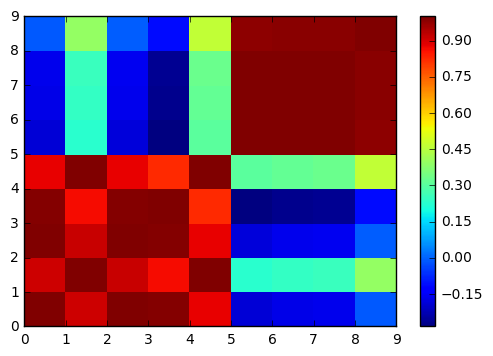

In [26]:
from pylab import pcolor, show, colorbar, xticks, yticks
%matplotlib inline

pcolor(index[lsi[corpus]])
colorbar()
show()

In [28]:
index.save('deerwester.index')
index = similarities.MatrixSimilarity.load('deerwester.index')

2017-02-02 07:33:17,196 : INFO : saving MatrixSimilarity object under deerwester.index, separately None
2017-02-02 07:33:17,204 : INFO : saved deerwester.index
2017-02-02 07:33:17,206 : INFO : loading MatrixSimilarity object from deerwester.index
2017-02-02 07:33:17,208 : INFO : loaded deerwester.index


Теперь оценим похожесть нашего запроса и документов из корпуса, используя косинусную меру

In [29]:
sims = index[vec_lsi] # perform a similarity query against the corpus
print(list(enumerate(sims))) # print (document_number, document_similarity) 2-tuples

[(0, 0.99809301), (1, 0.93748635), (2, 0.99844527), (3, 0.9865886), (4, 0.90755945), (5, -0.12416792), (6, -0.10639259), (7, -0.098794639), (8, 0.050041765)]


In [30]:
sims = sorted(enumerate(sims), key=lambda item: -item[1])
print(sims) # print sorted (document number, similarity score) 2-tuples

[(2, 0.99844527), (0, 0.99809301), (3, 0.9865886), (1, 0.93748635), (4, 0.90755945), (8, 0.050041765), (7, -0.098794639), (6, -0.10639259), (5, -0.12416792)]


## Векторное представление слов - word2vec

Цель векторно представления слов - находить отношения между словами и оценивать их семантику: vec(“king”) – vec(“man”) + vec(“woman”) =~ vec(“queen”) или vec(“Montreal Canadiens”) – vec(“Montreal”) + vec(“Toronto”) =~ vec(“Toronto Maple Leafs”)

In [32]:
sentences = [['first', 'sentence'], ['second', 'sentence']]
# train word2vec on the two sentences
model = models.Word2Vec(sentences, min_count=1)

2017-02-02 07:44:06,808 : INFO : collecting all words and their counts
2017-02-02 07:44:06,811 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-02-02 07:44:06,813 : INFO : collected 3 word types from a corpus of 4 raw words and 2 sentences
2017-02-02 07:44:06,814 : INFO : Loading a fresh vocabulary
2017-02-02 07:44:06,816 : INFO : min_count=1 retains 3 unique words (100% of original 3, drops 0)
2017-02-02 07:44:06,818 : INFO : min_count=1 leaves 4 word corpus (100% of original 4, drops 0)
2017-02-02 07:44:06,819 : INFO : deleting the raw counts dictionary of 3 items
2017-02-02 07:44:06,821 : INFO : sample=0.001 downsamples 3 most-common words
2017-02-02 07:44:06,823 : INFO : downsampling leaves estimated 0 word corpus (5.7% of prior 4)
2017-02-02 07:44:06,825 : INFO : estimated required memory for 3 words and 100 dimensions: 3900 bytes
2017-02-02 07:44:06,837 : INFO : resetting layer weights
2017-02-02 07:44:06,839 : INFO : training model with 3 workers o

In [33]:
print(model)
print(model.wv.vocab)

Word2Vec(vocab=3, size=100, alpha=0.025)
{'second': <gensim.models.word2vec.Vocab object at 0x000001E3625E40F0>, 'first': <gensim.models.word2vec.Vocab object at 0x000001E3625D63C8>, 'sentence': <gensim.models.word2vec.Vocab object at 0x000001E362658F28>}


Возьмем корпус побольше и создадим свой потоковый источник предложений

In [34]:
class MyText(object):
    def __iter__(self):
        for line in open('../data/lee_background.cor'):
            # assume there's one document per line, tokens separated by whitespace
            yield line.lower().split()

sentences = MyText()

print(sentences)

Результат обучения модели - матрица размера  #vocabulary x #size. У модели word2vec есть несколько настроек

In [38]:
# default value of min_count=5
model = models.Word2Vec(sentences, min_count=10)

2017-02-02 07:50:52,473 : INFO : collecting all words and their counts
2017-02-02 07:50:52,476 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-02-02 07:50:52,508 : INFO : collected 10186 word types from a corpus of 59890 raw words and 300 sentences
2017-02-02 07:50:52,509 : INFO : Loading a fresh vocabulary
2017-02-02 07:50:52,520 : INFO : min_count=10 retains 806 unique words (7% of original 10186, drops 9380)
2017-02-02 07:50:52,521 : INFO : min_count=10 leaves 40964 word corpus (68% of original 59890, drops 18926)
2017-02-02 07:50:52,527 : INFO : deleting the raw counts dictionary of 10186 items
2017-02-02 07:50:52,529 : INFO : sample=0.001 downsamples 54 most-common words
2017-02-02 07:50:52,533 : INFO : downsampling leaves estimated 26224 word corpus (64.0% of prior 40964)
2017-02-02 07:50:52,539 : INFO : estimated required memory for 806 words and 100 dimensions: 1047800 bytes
2017-02-02 07:50:52,548 : INFO : resetting layer weights
2017-02-02 07:5

In [40]:
# default value of size=100
model = models.Word2Vec(sentences, size=200)

2017-02-02 07:51:52,820 : INFO : collecting all words and their counts
2017-02-02 07:51:52,823 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-02-02 07:51:52,849 : INFO : collected 10186 word types from a corpus of 59890 raw words and 300 sentences
2017-02-02 07:51:52,851 : INFO : Loading a fresh vocabulary
2017-02-02 07:51:52,861 : INFO : min_count=5 retains 1723 unique words (16% of original 10186, drops 8463)
2017-02-02 07:51:52,864 : INFO : min_count=5 leaves 46858 word corpus (78% of original 59890, drops 13032)
2017-02-02 07:51:52,878 : INFO : deleting the raw counts dictionary of 10186 items
2017-02-02 07:51:52,887 : INFO : sample=0.001 downsamples 49 most-common words
2017-02-02 07:51:52,889 : INFO : downsampling leaves estimated 32849 word corpus (70.1% of prior 46858)
2017-02-02 07:51:52,891 : INFO : estimated required memory for 1723 words and 200 dimensions: 3618300 bytes
2017-02-02 07:51:52,904 : INFO : resetting layer weights
2017-02-02 07:

In [42]:
# default value of workers=3 (tutorial says 1...)
model = models.Word2Vec(sentences, workers=4)

2017-02-02 07:52:20,489 : INFO : collecting all words and their counts
2017-02-02 07:52:20,492 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-02-02 07:52:20,517 : INFO : collected 10186 word types from a corpus of 59890 raw words and 300 sentences
2017-02-02 07:52:20,518 : INFO : Loading a fresh vocabulary
2017-02-02 07:52:20,529 : INFO : min_count=5 retains 1723 unique words (16% of original 10186, drops 8463)
2017-02-02 07:52:20,530 : INFO : min_count=5 leaves 46858 word corpus (78% of original 59890, drops 13032)
2017-02-02 07:52:20,539 : INFO : deleting the raw counts dictionary of 10186 items
2017-02-02 07:52:20,541 : INFO : sample=0.001 downsamples 49 most-common words
2017-02-02 07:52:20,543 : INFO : downsampling leaves estimated 32849 word corpus (70.1% of prior 46858)
2017-02-02 07:52:20,545 : INFO : estimated required memory for 1723 words and 100 dimensions: 2239900 bytes
2017-02-02 07:52:20,559 : INFO : resetting layer weights
2017-02-02 07:

In [53]:
model = models.Word2Vec(sentences)

2017-02-02 08:29:29,221 : INFO : collecting all words and their counts
2017-02-02 08:29:29,225 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-02-02 08:29:29,250 : INFO : collected 10186 word types from a corpus of 59890 raw words and 300 sentences
2017-02-02 08:29:29,251 : INFO : Loading a fresh vocabulary
2017-02-02 08:29:29,265 : INFO : min_count=5 retains 1723 unique words (16% of original 10186, drops 8463)
2017-02-02 08:29:29,269 : INFO : min_count=5 leaves 46858 word corpus (78% of original 59890, drops 13032)
2017-02-02 08:29:29,283 : INFO : deleting the raw counts dictionary of 10186 items
2017-02-02 08:29:29,287 : INFO : sample=0.001 downsamples 49 most-common words
2017-02-02 08:29:29,290 : INFO : downsampling leaves estimated 32849 word corpus (70.1% of prior 46858)
2017-02-02 08:29:29,295 : INFO : estimated required memory for 1723 words and 100 dimensions: 2239900 bytes
2017-02-02 08:29:29,310 : INFO : resetting layer weights
2017-02-02 08:

Мы можем как постепенно дообучать модель (онлайн обучение), так и зафиксировать ее

In [54]:
model.init_sims(replace=True)

2017-02-02 08:29:35,440 : INFO : precomputing L2-norms of word weight vectors


Word2vec поддерживает ряд втроенных функций по оценке схожести

In [55]:
model.most_similar(positive=['human', 'crime'], negative=['party'], topn=1)

[('growing', 0.9911920428276062)]

In [56]:
model.doesnt_match("input is lunch he sentence cat".split())

'sentence'

In [57]:
print(model.similarity('human', 'party'))
print(model.similarity('tree', 'murder'))

0.998945122757
0.995429865781


In [58]:
model['human']

array([ 0.02571549,  0.05654283,  0.08735893,  0.06042101,  0.1080929 ,
       -0.02331162, -0.0018254 ,  0.06333245, -0.05215555,  0.06805436,
       -0.06000465, -0.24123077, -0.1084304 ,  0.11672158, -0.14518464,
       -0.10641909,  0.20966332, -0.04578859, -0.00279448, -0.03958187,
        0.02091216,  0.19292636, -0.02010854, -0.01896548, -0.01460866,
       -0.09219701, -0.00053441, -0.02324938, -0.14263582,  0.1107691 ,
        0.13305394,  0.05190931, -0.02660829,  0.02601514,  0.02034386,
       -0.09105876,  0.0669838 , -0.22144325, -0.08958331, -0.13569823,
       -0.00048439, -0.01253671,  0.03806499,  0.0325041 ,  0.06020157,
        0.30387774, -0.0797781 , -0.0440162 ,  0.19684649,  0.04818842,
       -0.00277689, -0.10702567,  0.03451814,  0.02370303,  0.03958154,
       -0.01678191,  0.09321268, -0.15446551,  0.02200461,  0.02116641,
       -0.11456019,  0.01065565, -0.02430117,  0.03892392, -0.02115884,
        0.13492824, -0.00146681,  0.01885894, -0.03583477, -0.05

In [61]:
model.most_similar(positive=['park', 'questions'], negative=['reduce'], topn=5)

[('muslim', 0.9961795806884766),
 ('warned', 0.9960293769836426),
 ('abuse', 0.9959511160850525),
 ('week', 0.9958263635635376),
 ('minister,', 0.9958088397979736)]

In [ ]:
model.accuracy('../data/questions-words.txt')

Мы можем в качестве "слов" использовать биграммы

In [52]:
bigram_transformer = models.Phrases(sentences)
model = models.Word2Vec(bigram_transformer[sentences], size=100)

2017-02-02 08:10:31,670 : INFO : collecting all words and their counts
2017-02-02 08:10:31,674 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2017-02-02 08:10:31,862 : INFO : collected 48026 word types from a corpus of 59590 words (unigram + bigrams) and 300 sentences
2017-02-02 08:10:31,864 : INFO : using 48026 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
C:\Users\sanek\Anaconda3\lib\site-packages\gensim\models\phrases.py:248: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
2017-02-02 08:10:31,910 : INFO : collecting all words and their counts
2017-02-02 08:10:31,916 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-02-02 08:10:32,219 : INFO : collected 10440 word types from a corpus of 56279 raw words and 300 sentences
2017-02-02 08:10:32,220 : INFO : Loading 

## Для дальнейшего изучения
* Подробнее про Dictionary и doc2bow https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/Corpora_and_Vector_Spaces.ipynb
* Latent semantic analysis/indexing как SVD  http://nbviewer.jupyter.org/url/cslu.ohsu.edu/~gormanky/courses/CS662/Notebooks/CS-562-662-latent-semantic-analyis.ipynb 
* LSA и LDA в gensim: https://radimrehurek.com/gensim/wiki.html 
* Дистрибутивные модели в PyDSM https://github.com/jimmycallin/notebooks/blob/master/PyDSM%20Meetup%20Presentation.ipynb 
* Дистрибутивные модели для русского: http://ling.go.mail.ru/dsm/ru/ (можно посмотреть разные примеры и разные функции на сайте, например, сексизм в “похожих словах” интеллектуал VS интеллектуалка, ассоциации (у меня нашлась забавная волосы : шампунь = зуб : паста) 